In [5]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties as unc

In [6]:
def transfer(F, Cap, R):
    CIn = unc.ufloat(25e-12,05e-12)
    C = (Cap)*(CIn)/(Cap + CIn)
    Rin = unc.ufloat(1e6, 0.5e6)
    omega = 2*np.pi*F
    return 1/((R/Rin+1)**2+(omega*C*R)**2)**0.5

def curveFit(f, f4, a):
    return np.sqrt(a**2 + f4**2*f**-1)

def readData(fileName: str):
    data = pd.read_csv(fileName, sep="\t", header=None)
    return data[0], data[1]
def expected(f, c, d, T):
    return (4*1.380649e-23*T*(d/(2*np.pi*f*c)))**0.5

def expectedSlope(c,d,T):
    return (4*1.380649e-23*T/(2*np.pi*c))**0.5



In [7]:
_, uncsV = readData("uncs.txt")
five = uncsV[0:20]
hundred = uncsV[20:40]
thousand = uncsV[40:60]
uncPctFive = np.std(five)/np.mean(five)
uncPctHundred = np.std(hundred)/np.mean(hundred)
uncPctThousand = np.std(thousand)/np.mean(thousand)
print(uncPctFive, uncPctHundred, uncPctThousand)

0.06405111704962811 0.14300066995941668 0.20380011074927695


(4.39+/-0.34)e+04
Expected:  (7.4347+/-0.0015)e-06
Fit:  [3.0446909e-06 6.3716022e-08] [[ 1.78821968e-13 -6.49976251e-15]
 [-6.49976251e-15  1.17523600e-14]]


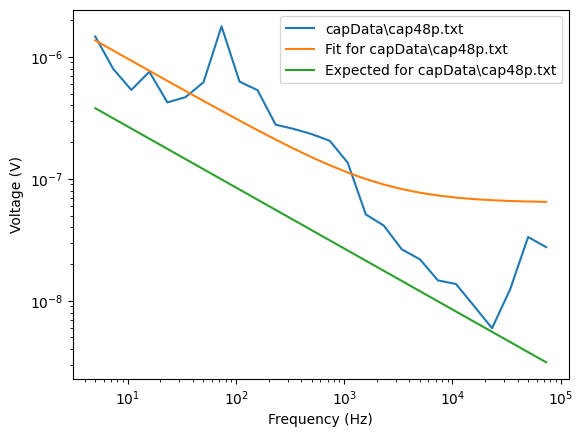

(8.0+/-2.7)e+03
Expected:  (6.5872+/-0.0012)e-06
Fit:  [2.69154871e-06 2.54816846e-08] [[ 7.00929436e-14 -2.35816483e-15]
 [-2.35816483e-15  7.67357891e-15]]


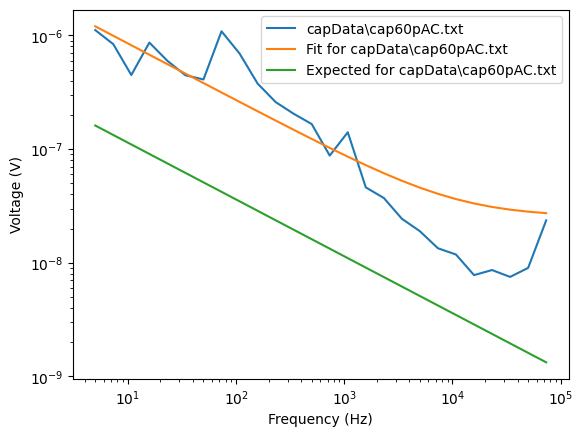

(6.5+/-2.2)e+03
Expected:  (5.9475+/-0.0011)e-06
Fit:  [3.22378036e-06 1.42034027e-07] [[ 1.42605578e-12 -5.89639003e-14]
 [-5.89639003e-14  6.41059095e-14]]


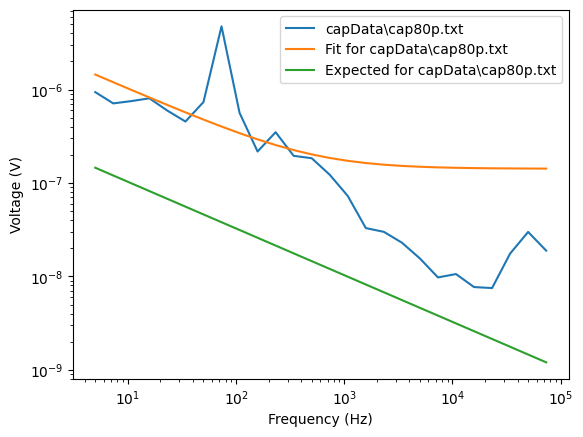

In [9]:
capacitances = [unc.ufloat(47.1, 0.01)*1e-12, unc.ufloat(60.0, 0.01)*1e-12, unc.ufloat(73.6, 0.01)*1e-12]
ds = [unc.ufloat(0.013, 0.001), unc.ufloat(0.003, 0.001), unc.ufloat(0.003, 0.001)]
data = glob.glob("capData/*.txt")
T = unc.ufloat(273.3 + 22.9, 0.1)
for file, cap, d in zip(data, capacitances, ds):
    f, V = readData(file)
    R = d/(2*np.pi*1e3*cap)
    print(R)
    vsWithUnc = [unc.ufloat(v, uncPctHundred)/transfer(F, cap, R) for v, F in zip(V, f)]
    vsNoUnc = [v.n for v in vsWithUnc]
    vsUnc = [v.s for v in vsWithUnc]
    popt, pcov = curve_fit(curveFit, f, vsNoUnc, p0=[0, 1], sigma=vsUnc)
    expect = []
    for F in f:
        expect.append(expected(F, cap.n, d.n, T.n))
    plt.plot(f, vsNoUnc, label=file)
    plt.plot(f, curveFit(f, *popt), label="Fit for " + file)
    plt.plot(f, expect, label="Expected for " + file)
    print("Expected: ", expectedSlope(cap, d, T))
    print("Fit: ", popt, pcov)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.show()